In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pycmap
import seaborn as sns
from tlviz.factor_tools import factor_match_score
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# div_hexes = ['#7222D3', neutral_color, '#FF780A']
# div_cmap = get_continuous_cmap(div_hexes)


In [3]:
# helper functions

def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


# import data
### cluster data

In [4]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:           (bootstrap: 100, replicate: 3, component: 20,
                       ortholog: 5084, clade: 3, samplename: 76)
Coordinates:
  * bootstrap         (bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * replicate         (replicate) object 'A' 'B' 'C'
  * component         (component) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20
  * ortholog          (ortholog) int64 60000001 60000002 ... 60040287 60040292
  * clade             (clade) object 'HLI' 'HLII' 'LLI'
  * samplename        (samplename) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.N...
Data variables:
    componentweights  (bootstrap, replicate, component) float64 ...
    geneweights       (bootstrap, replicate, component, ortholog) float64 ...
    taxonweights      (bootstrap, replicate, component, clade) float64 ...
    sampleweights     (bootstrap, replicate, component, samplename) float64 ...
    sample            (bootstrap, replicate, samplename) object ...

In [5]:
# read in metadata

sample_df = pd.read_csv('../../data/metadata/archive/sample_metadata_merged.csv')

# define salinity and chlorophyll fronts
# source: Juranek et al., 2020 https://doi.org/10.1029/2020GB006702
sal_fronts = {2016: 32.15, 2017: 32.5, 2019: 32.34}
chl_fronts = {2016: 33, 2017: 36.2, 2019: 35}

sample_df


,samplename,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [6]:
# pull out clusters hypothesized to relate to iron limitation

pro8_df = pro_ds.sel(component=8).sampleweights.to_series().reset_index()
pro8_df['genus'] = 'Prochlorococcus'
syn5_df = syn_ds.sel(component=5).sampleweights.to_series().reset_index()
syn5_df['genus'] = 'Synechococcus'

fe_cluster_df = pd.concat([pro8_df, syn5_df]).reset_index(drop=True)
fe_cluster_df = pd.merge(fe_cluster_df, sample_df, on='samplename', how='left')

fe_cluster_df


,bootstrap,replicate,samplename,sampleweights,genus,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/22/16 5:40,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,0.341925,Prochlorococcus,Gradients 1,2016,4/24/16 5:37,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.022443,Prochlorococcus,Gradients 1,2016,4/26/16 5:43,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.219431,Prochlorococcus,Gradients 1,2016,4/27/16 5:41,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48895,99,C,G3.UW.NS.UW35_2.7m,0.080191,Synechococcus,Gradients 3,2019,4/26/19 5:55,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
48896,99,C,G3.UW.NS.UW37_1.7m,0.092974,Synechococcus,Gradients 3,2019,4/20/19 6:12,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
48897,99,C,G3.UW.NS.UW38_1.7m,0.229257,Synechococcus,Gradients 3,2019,4/15/19 5:37,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
48898,99,C,G3.UW.NS.UW40_1.7m,0.168009,Synechococcus,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


# import data
### environmental data (CMAP)

In [7]:
# import data from cmap

api = pycmap.API(token='55bd80f9-8d5d-4c8f-8917-f5b0e924ed45')
api.search_catalog('iron John gradients')


,Variable,Table_Name,Long_Name,Unit,Make,Sensor,Process_Level,Study_Domain,Temporal_Resolution,Spatial_Resolution,...,Data_Source,Distributor,Dataset_Description,Acknowledgement,Dataset_ID,ID,Visualize,Keywords,Unstructured_Dataset_Metadata,Unstructured_Variable_Metadata
0,Fe_dissolved,tblKM1906_Gradients3_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,522,10691,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
1,Fe_dissolved,tblKOK1606_Gradients1_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,548,11060,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
2,Fe,tblMGL1704_Gradients2_Trace_Metals,Dissolved Iron Concentrations,nM,Observation,Towfish,Reprocessed,Chemistry+Biogeochemistry,Irregular,Irregular,...,John Lab USC,John Lab - USC,Samples were collected in the North Pacific on...,John Lab - USC,575,11510,1,"biogeochemistry, chemistry, cruise, dissolved ...",NaN,NaN
3,Fe_dissolved,tblMGL1704_Gradients2_Diss_Trace_Metal_Profile,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,547,11054,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN
4,Fe_dissolved,tblMGL1704_Gradients2_Diss_Trace_Metal_Surface,Dissolved Iron Concentrations,nmol/L,Observation,ICP-MS,Reprocessed,Chemistry,Irregular,Irregular,...,"John Lab, University of Southern California","John Lab, University of Southern California",Samples were collected in the North Pacific on...,Sample collection and analysis was supported b...,546,11048,1,"biogeochemistry, chemistry, cruise, Dissolved ...",NaN,NaN


In [8]:
# import all iron data from G1, G2, G3

fe_df = pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Surface'), 
    api.get_dataset('tblKM1906_Gradients3_Diss_Trace_Metal_Profile')
]).reset_index(drop=True)
fe_df['year'] = pd.to_datetime(fe_df['time']).dt.year

fe_df


,time,lat,lon,depth,Cd_dissolved,Pb_dissolved,Fe_dissolved,Ni_dissolved,Cu_dissolved,Zn_dissolved,Mn_dissolved,Co_dissolved,year
0,2016-04-20T08:00:00,23.500000,-158.00000,15.0,0.000000,42.387016,0.133943,2.112766,0.520765,0.406267,0.978415,2.886313,2016
1,2016-04-20T08:00:00,23.500000,-158.00000,45.0,0.000000,40.404233,0.112573,2.144578,0.487953,0.041618,0.956071,1.607434,2016
2,2016-04-20T08:00:00,23.500000,-158.00000,130.0,2.619439,38.345184,0.148592,2.123560,0.530634,0.376382,0.616861,5.833796,2016
3,2016-04-20T08:00:00,23.500000,-158.00000,150.0,9.897086,40.218990,0.397744,2.192099,0.562793,0.346099,0.508902,5.351234,2016
4,2016-04-20T08:00:00,23.500000,-158.00000,200.0,56.298971,70.479227,0.402671,2.449607,0.689346,0.183127,0.334094,11.862347,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2019-04-24T00:00:00,42.333888,-158.00595,75.0,0.156920,0.051880,0.423880,3.489863,1.107804,0.624393,0.859485,0.016049,2019
357,2019-04-24T00:00:00,42.333888,-158.00595,100.0,0.208297,0.069508,1.140576,3.679030,1.401452,2.271989,0.795996,0.021737,2019
358,2019-04-24T00:00:00,42.333888,-158.00595,200.0,0.436411,0.078711,1.454341,4.160885,1.469514,3.321238,0.484288,0.027267,2019
359,2019-04-24T00:00:00,42.333888,-158.00595,300.0,0.581454,0.082272,1.584558,4.917585,1.768565,4.342330,0.446200,0.029886,2019


In [9]:
# import nitrogen data

# dissolved nitrate+nitrite (Karl lab)
n_diss_df =  pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Nutrients'), 
    api.get_dataset('tblMGL1704_Gradients2_Nutrients'), 
    api.get_dataset('tblKM1906_Gradients3_Organic_Inorganic_Nutrients').rename(columns={'NO3_plus_NO2': 'NO3_NO2'})
]).reset_index(drop=True)
n_diss_df['year'] = pd.to_datetime(n_diss_df['time']).dt.year

# particulate nitrogen (White lab)
n_part_df =  pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_PPPCPN_UW'), 
    api.get_dataset('tblMGL1704_Gradients2_PPPCPN_UW'), 
    api.get_dataset('tblKM1906_Gradients3_PCPN_UW')
]).reset_index(drop=True)
n_part_df['year'] = pd.to_datetime(n_part_df['time']).dt.year

n_diss_df


,time,lat,lon,depth,Station,Cast,RosPos,SiO4,NO3_NO2,PO4,TOC,NH4,TN,TON,TP,T_OP,NO2,year
0,2016-04-21T00:03:10,23.571167,-157.916000,397.221491,2 ...,5.0,5.0,NaN,NaN,NaN,43.900000,NaN,NaN,NaN,NaN,NaN,NaN,2016
1,2016-04-21T00:08:24,23.571167,-157.916000,199.103758,2 ...,5.0,6.0,NaN,NaN,NaN,50.700000,NaN,NaN,NaN,NaN,NaN,NaN,2016
2,2016-04-21T00:10:30,23.571167,-157.916000,149.770405,2 ...,5.0,7.0,NaN,NaN,NaN,54.400000,NaN,NaN,NaN,NaN,NaN,NaN,2016
3,2016-04-21T00:12:34,23.571167,-157.916000,105.063300,2 ...,5.0,8.0,NaN,NaN,NaN,66.800000,NaN,NaN,NaN,NaN,NaN,NaN,2016
4,2016-04-21T00:15:43,23.571167,-157.916000,119.046488,2 ...,5.0,12.0,NaN,NaN,NaN,62.300000,NaN,NaN,NaN,NaN,NaN,NaN,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2019-04-27T06:04:59,33.230865,-157.998872,7.000000,Underway56,NaN,NaN,NaN,0.009382,0.044702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
428,2019-04-27T08:50:11,32.721290,-157.999772,7.000000,Underway57,NaN,NaN,NaN,0.006008,0.040763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
429,2019-04-27T11:55:46,32.161412,-157.999878,7.000000,Underway58,NaN,NaN,NaN,0.012590,0.025703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
430,2019-04-27T15:22:00,31.537025,-157.993222,7.000000,Underway59,NaN,NaN,3.07206,0.013660,0.061354,59.815844,0.016635,4.149282,4.135623,0.212595,0.151241,0.004416,2019


In [10]:
# import optics

# No ACS or ECO measurements in G1. HPLC measurements available for pigments.

# optical measurements (White lab)
optics_df =  pd.concat([
    api.get_dataset('tblGradients2_MGL1704_Optics_LISST_ACS_ECO'), 
    api.get_dataset('tblKM1906_Gradients3_Optics_LISST_ACS_ECO')
]).reset_index(drop=True)
optics_df['year'] = pd.to_datetime(optics_df['time']).dt.year

optics_df


,time,lat,lon,depth,vol_lisst_sm,vol_lisst_mid,vol_lisst_lg,particle_num,cp,chla_acs,chla_eco,scatter_eco,year
0,2017-05-28T07:36:00,21.310000,-158.230000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000064,2017
1,2017-05-28T07:37:00,21.310000,-158.230000,5,0.006220,0.058342,0.080201,4.466687e+06,NaN,NaN,NaN,0.000064,2017
2,2017-05-28T07:38:00,21.310000,-158.230000,5,0.004098,0.057848,0.088040,3.413742e+06,NaN,NaN,0.024995,0.000067,2017
3,2017-05-28T07:39:00,21.310000,-158.230000,5,0.002535,0.057887,0.091885,2.639392e+06,NaN,NaN,0.024666,0.000066,2017
4,2017-05-28T07:40:00,21.310000,-158.230000,5,0.001713,0.060553,0.083490,2.034229e+06,NaN,NaN,0.025198,0.000069,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47551,2019-04-28T22:47:00,25.549263,-157.999727,6,0.003109,0.059196,0.014539,NaN,NaN,NaN,0.015693,0.000259,2019
47552,2019-04-28T22:48:00,25.545780,-157.999718,6,0.002869,0.061041,0.014281,NaN,NaN,NaN,0.016413,0.000261,2019
47553,2019-04-28T22:49:00,25.542282,-157.999616,6,0.002984,0.060576,0.018100,NaN,NaN,NaN,0.017237,0.000262,2019
47554,2019-04-28T22:50:00,25.538776,-157.999610,6,0.003148,0.059972,0.013868,NaN,NaN,NaN,0.017940,0.000262,2019


## join N & Fe data on samples

In [11]:
# match sample data with dissolved Fe and dissolved N data

# only select surface and depth samples for joining
source_df = sample_df[sample_df.samplegroup.isin(
    ['depth profiles', 'surface transect'])].reset_index(drop=True).rename(
    columns={'datetime': 'time', 'latitude': 'lat', 'longitude': 'lon'})
source_cols = source_df.columns.to_list()

# define target datasets
targets = {
    # dissolved Fe
    'tblKOK1606_Gradients1_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 15]
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 15]
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Surface': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 15]
    },
    'tblKM1906_Gradients3_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 15]
    }, 
    # dissolved N
    'tblKOK1606_Gradients1_Nutrients': {
        'variables': ['NO3_NO2'], 
        'tolerances': [1, 0.25, 0.25, 15]
    },
    'tblMGL1704_Gradients2_Nutrients': {
        'variables': ['NO3_NO2'], 
        'tolerances': [1, 0.25, 0.25, 15]
    },
    'tblKM1906_Gradients3_Organic_Inorganic_Nutrients': {
        'variables': ['NO3_plus_NO2'], 
        'tolerances': [1, 0.25, 0.25, 15]
    }
}

# join target data on the source dataframe
merged_df = pycmap.Sample(
    source=source_df, 
    targets=targets, 
    replaceWithMonthlyClimatolog=False
)

# merge all of the iron data into one column
fe_start = 'CMAP_Fe_dissolved_tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'
fe_end = 'CMAP_Fe_dissolved_tblKM1906_Gradients3_Diss_Trace_Metal_Profile'
merged_df['Fe_dissolved'] = merged_df.loc[:, fe_start:fe_end].max(axis=1)

# merge all of the n data into one column
n_start = 'CMAP_NO3_NO2_tblKOK1606_Gradients1_Nutrients'
n_end = 'CMAP_NO3_plus_NO2_tblKM1906_Gradients3_Organic_Inorganic_Nutrients'
merged_df['NO3_NO2'] = merged_df.loc[:, n_start:n_end].max(axis=1)

# trim the dataframe
merged_df = merged_df[source_cols + ['Fe_dissolved', 'NO3_NO2']]

merged_df


Gathering metadata .... 
Sampling starts
Sampling finished                                                                                                      

,samplename,cruise,year,time,lat,lon,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint,Fe_dissolved,NO3_NO2
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN,0.129157,0.194229
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN,0.153418,0.113817
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN,0.292891,1.132050
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002000,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN,0.385588,1.680196
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050000,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN,NaN,6.554901
5,G3.DEPTH.NS.S4C6.50m,Gradients 3,2019,4/16/19 8:03,41.670000,-158.050000,50,Gradients 3 depth profile,depth profiles,0.34,10am,NaN,NaN,NaN,NaN,0.320307,6.457702
6,G3.DEPTH.NS.S5C8.125m,Gradients 3,2019,4/20/19 7:56,37.000000,-158.000000,125,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN,NaN,1.705125
7,G3.DEPTH.NS.S5C8.55m,Gradients 3,2019,4/20/19 8:00,37.000000,-158.000000,55,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN,NaN,0.210065
8,G3.DEPTH.NS.S6C7.130m,Gradients 3,2019,4/22/19 6:36,32.920000,-158.000000,130,Gradients 3 depth profile,depth profiles,0.28,6am,NaN,NaN,NaN,NaN,0.498618,0.522724
9,G3.DEPTH.NS.S6C7.75m,Gradients 3,2019,4/22/19 6:40,32.920000,-158.000000,75,Gradients 3 depth profile,depth profiles,0.28,6am,NaN,NaN,NaN,NaN,0.388151,0.007670


In [12]:
# merge Fe data on dissolved N data

# only select surface and depth samples for joining
source_df = n_diss_df.copy()
source_cols = source_df.columns.to_list()

# define target datasets
targets = {
    # dissolved Fe
    'tblKOK1606_Gradients1_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 5]
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 5]
    },
    'tblMGL1704_Gradients2_Diss_Trace_Metal_Surface': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 5]
    },
    'tblKM1906_Gradients3_Diss_Trace_Metal_Profile': {
        'variables': ['Fe_dissolved'], 
        'tolerances': [1, 0.25, 0.25, 5]
    }
}

# join target data on the source dataframe
merged_df = pycmap.Sample(
    source=source_df, 
    targets=targets, 
    replaceWithMonthlyClimatolog=False
)

# merge all of the iron data into one column
fe_start = 'CMAP_Fe_dissolved_tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'
fe_end = 'CMAP_Fe_dissolved_tblKM1906_Gradients3_Diss_Trace_Metal_Profile'
merged_df['Fe_dissolved'] = merged_df.loc[:, fe_start:fe_end].max(axis=1)

# trim the dataframe
merged_df = merged_df[source_cols + ['Fe_dissolved']]

# calculate ratio
merged_df['N:Fe'] = merged_df['NO3_NO2'] / merged_df['Fe_dissolved']

merged_df


Gathering metadata .... 
Sampling starts
Sampling finished                                                                                                      

,time,lat,lon,depth,Station,Cast,RosPos,SiO4,NO3_NO2,PO4,TOC,NH4,TN,TON,TP,T_OP,NO2,year,Fe_dissolved,N:Fe
0,2016-04-21T00:03:10,23.571167,-157.916000,397.221491,2 ...,5.0,5.0,NaN,NaN,NaN,43.900000,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.432769,NaN
1,2016-04-21T00:08:24,23.571167,-157.916000,199.103758,2 ...,5.0,6.0,NaN,NaN,NaN,50.700000,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.402671,NaN
2,2016-04-21T00:10:30,23.571167,-157.916000,149.770405,2 ...,5.0,7.0,NaN,NaN,NaN,54.400000,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.397744,NaN
3,2016-04-21T00:12:34,23.571167,-157.916000,105.063300,2 ...,5.0,8.0,NaN,NaN,NaN,66.800000,NaN,NaN,NaN,NaN,NaN,NaN,2016,NaN,NaN
4,2016-04-21T00:15:43,23.571167,-157.916000,119.046488,2 ...,5.0,12.0,NaN,NaN,NaN,62.300000,NaN,NaN,NaN,NaN,NaN,NaN,2016,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2019-04-27T06:04:59,33.230865,-157.998872,7.000000,Underway56,NaN,NaN,NaN,0.009382,0.044702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
428,2019-04-27T08:50:11,32.721290,-157.999772,7.000000,Underway57,NaN,NaN,NaN,0.006008,0.040763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
429,2019-04-27T11:55:46,32.161412,-157.999878,7.000000,Underway58,NaN,NaN,NaN,0.012590,0.025703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN,NaN
430,2019-04-27T15:22:00,31.537025,-157.993222,7.000000,Underway59,NaN,NaN,3.07206,0.013660,0.061354,59.815844,0.016635,4.149282,4.135623,0.212595,0.151241,0.004416,2019,NaN,NaN


# plot data

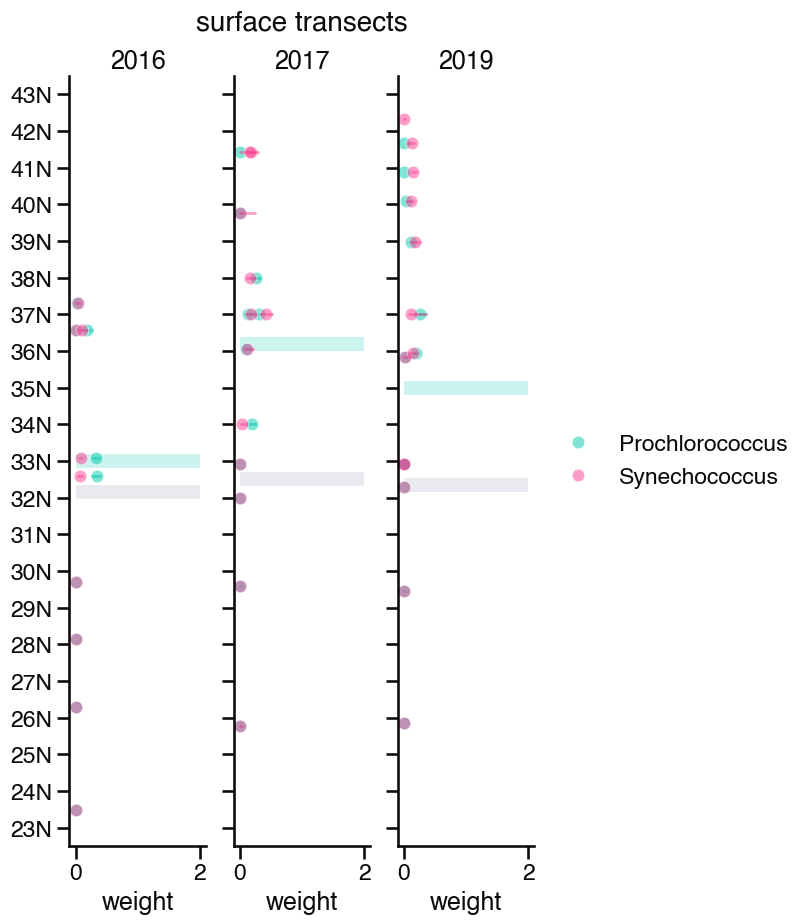

In [14]:
# plot surface transect data, exact sample location

# set up figure
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(6, 10))
rows = 1
cols = 3
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
n_bins = 21
bounds = (23, 43)

# set up data
fig_df = fe_cluster_df.copy()

# iterate through data
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0, i])
    if i == 1:
        axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data together
    plot_df = fig_df[fig_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # plot_df = plot_df.groupby(['genus', 'latitude']).sampleweights.median().reset_index()
    # plot salinity front
    axis.hlines(y=sal_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[5], alpha=0.2)
    # plot chlorophyll front
    axis.hlines(y=chl_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[2], alpha=0.2)
    # make figure
    sns.lineplot(
        data=plot_df, x='sampleweights', y='latitude', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], estimator='median', errorbar=('pi', 95), 
        err_style='bars', marker='o', linestyle='', alpha=0.5, orient='y', legend=(i==cols-1), ax=axis
    )
    axis.set(ylim=(bounds[0]-0.5, bounds[1]+0.5), ylabel='', xlabel='weight', title=year)
    if not i:
        axis.set_yticks(np.linspace(bounds[0], bounds[1], n_bins), [f'{int(l)}N' for l in np.linspace(bounds[0], bounds[1], num=n_bins)])
    else:
        axis.set_yticks(np.linspace(bounds[0], bounds[1], n_bins))
        axis.tick_params(left=True, labelleft=False)
    if i == cols-1:
        axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))


### dissolved N, dissolved Fe, particulate N, chlorophyll

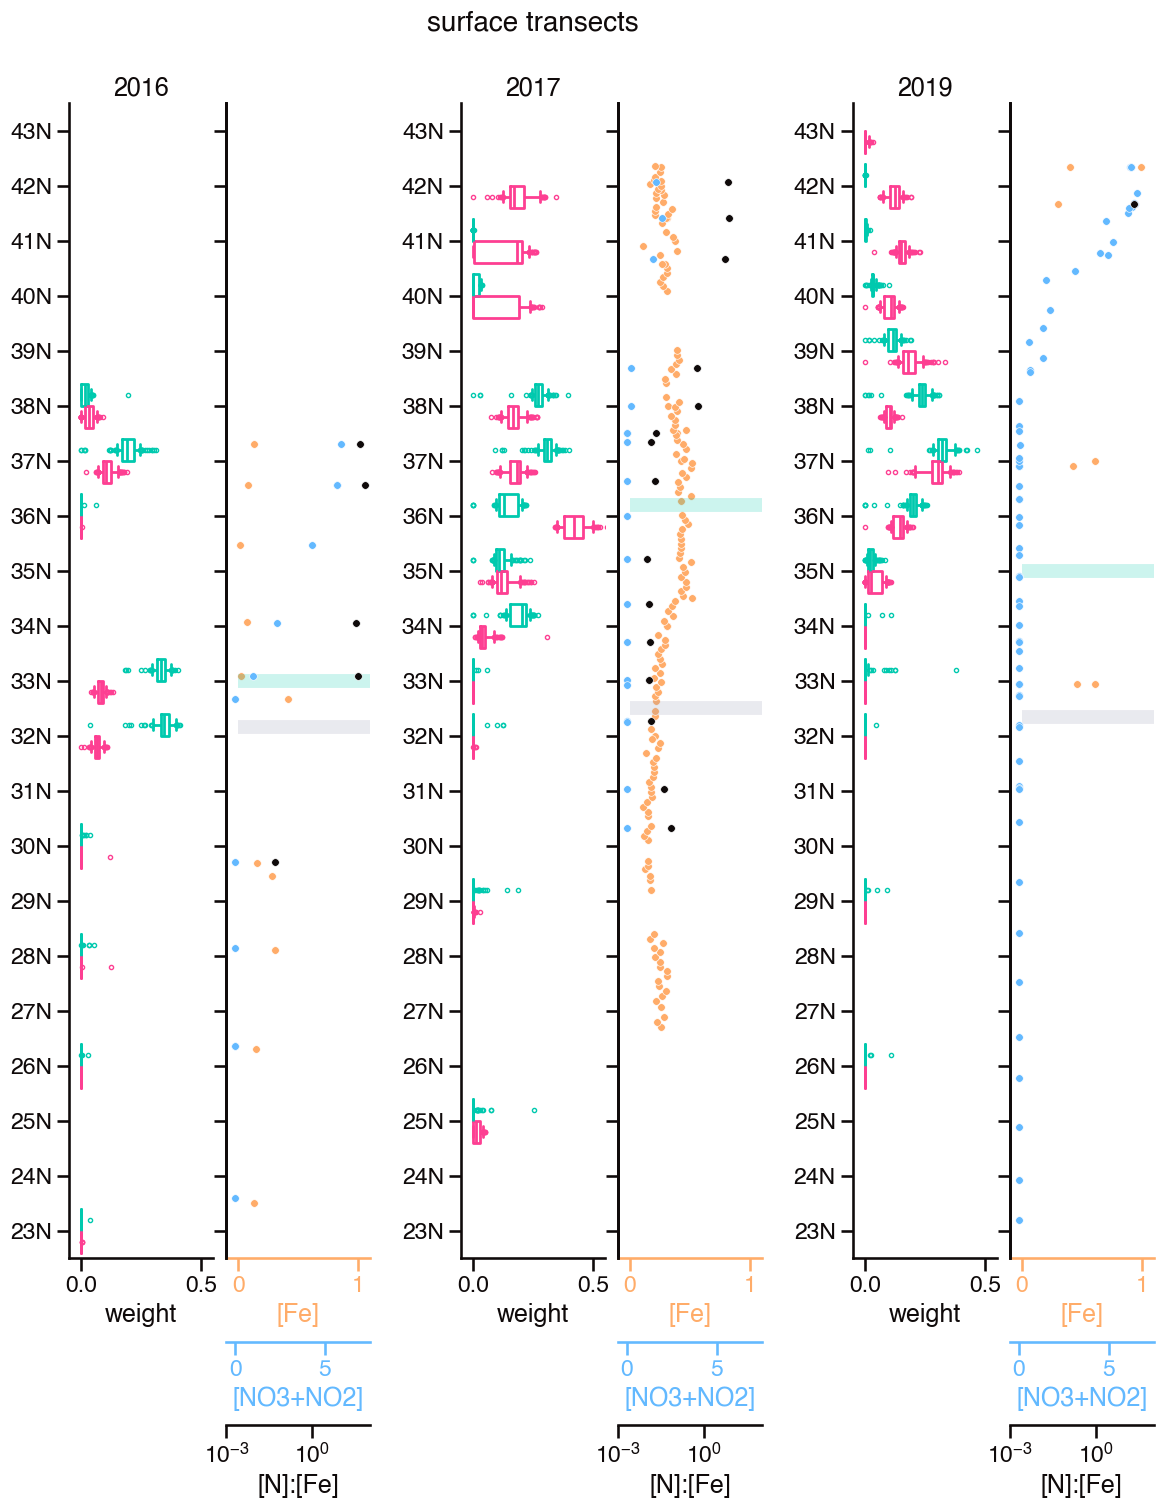

In [15]:
# plot surface transect data, binned sample location, environmental data added

# set up figure
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(15, 15))
rows = 1
cols = 15
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
n_bins = 21
bounds = (23, 43)

# plot cluster weight data
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0, 5*i:5*i+2])
    if i == 1:
        axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data together
    plot_df = fe_cluster_df[fe_cluster_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.boxplot(
        data=plot_df, x='sampleweights', y='lat_idx', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], 
        orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    )
    # set labels and such
    axis.set(xlim=sample_weight_range, ylabel='', xlabel='weight', title=year)
    axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])

# plot environmental covariates
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0, 5*i+2:5*i+4])
    # plot salinity front
    axis.hlines(y=sal_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[5], alpha=0.2)
    # plot chlorophyll front
    axis.hlines(y=chl_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[2], alpha=0.2)
    
    # dissolved iron
    color = sns.color_palette()[1]
    sns.scatterplot(
        data=fe_df[(fe_df['year'] == year) & (fe_df['depth'].le(15))], 
        x='Fe_dissolved', y='lat', 
        ax=axis, 
        color=color, 
        s=30
    )
    axis.set(xlim=(-.1, 1.1), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[Fe]', ylabel='')
    axis.tick_params(left=True, labelleft=False)
    axis.tick_params(axis='x', colors=color)
    axis.xaxis.label.set_color(color)
    axis.spines['bottom'].set_color(color)

    # dissolved nitrate + nitrite
    color = sns.color_palette()[7]
    axis2 = plt.twiny(axis)
    sns.scatterplot(
        data=n_diss_df[(n_diss_df['year'] == year) & (n_diss_df['depth'].le(15))], 
        x='NO3_NO2', y='lat', 
        ax=axis2, 
        color=color, 
        s=30
    )
    axis2.set(xlim=(-0.5, 7.5), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[NO3+NO2]', ylabel='')
    axis2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis2.tick_params(axis='x', colors=color)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.label.set_color(color)
    axis2.spines['bottom'].set_color(color)
    axis2.spines['bottom'].set_position(('outward', 60))

    # N:Fe ratio
    color = sns.color_palette()[4]
    axis3 = plt.twiny(axis2)
    sns.scatterplot(
        data=merged_df[(merged_df['year'] == year) & (merged_df['depth'].le(15))], 
        x='N:Fe', y='lat', 
        ax=axis3, 
        color=color, 
        s=30
    )
    axis3.set(xlim=(0.001, 100), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[N]:[Fe]', ylabel='', xscale='log')
    axis3.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis3.tick_params(axis='x', colors=color)
    axis3.xaxis.set_label_position('bottom')
    axis3.xaxis.label.set_color(color)
    axis3.spines['bottom'].set_color(color)
    axis3.spines['bottom'].set_position(('outward', 120))

    # # chlorophyll a
    # color = sns.color_palette()[9]
    # sns.lineplot(
    #     data=optics_df[(optics_df['year'] == year) & (optics_df['depth'].le(15))], 
    #     x='chla_eco', y='lat', color=color, alpha=0.5, orient='y', errorbar=None, ax=axis
    # )
    # axis.set(xlim=(-0.1, 2.1), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
    #          xlabel='[chl a]', ylabel='')
    # axis.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True, labelleft=False)
    # axis.tick_params(axis='x', colors=color)
    # axis.xaxis.set_label_position('bottom')
    # axis.xaxis.label.set_color(color)
    # axis.spines['bottom'].set_color(color)
    
    # # particulate nitrogen
    # color = sns.color_palette()[7]
    # axis2 = plt.twiny(axis)
    # sns.scatterplot(
    #     data=n_part_df[(n_part_df['year'] == year) & (n_part_df['depth'].le(15))], 
    #     x='pn', y='lat', 
    #     ax=axis2, 
    #     color=color, 
    #     s=30
    # )
    # axis2.set(xlim=(-.1, 3.1), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
    #          xlabel='particulate N', ylabel='')
    # axis2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    # axis2.tick_params(axis='x', colors=color)
    # axis2.xaxis.set_label_position('bottom')
    # axis2.xaxis.label.set_color(color)
    # axis2.spines['bottom'].set_color(color)
    # axis2.spines['bottom'].set_position(('outward', 60))
    
    # # dissolved nitrate + nitrite
    # color = sns.color_palette()[4]
    # axis3 = plt.twiny(axis2)
    # sns.scatterplot(
    #     data=n_diss_df[(n_diss_df['year'] == year) & (n_diss_df['depth'].le(15))], 
    #     x='NO3_NO2', y='lat', 
    #     ax=axis3, 
    #     color=color, 
    #     s=30
    # )
    # axis3.set(xlim=(-0.5, 7.5), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
    #          xlabel='[NO3+NO2]', ylabel='')
    # axis3.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    # axis3.tick_params(axis='x', colors=color)
    # axis3.xaxis.set_label_position('bottom')
    # axis3.xaxis.label.set_color(color)
    # axis3.spines['bottom'].set_color(color)
    # axis3.spines['bottom'].set_position(('outward', 120))
    
    # # chlorophyll a
    # color = sns.color_palette()[9]
    # axis4 = plt.twiny(axis3)
    # sns.lineplot(
    #     data=optics_df[(optics_df['year'] == year) & (optics_df['depth'].le(15))], 
    #     x='chla_eco', y='lat', color=color, alpha=0.5, orient='y', errorbar=None, ax=axis4
    # )
    # axis4.set(xlim=(-0.1, 2.1), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
    #          xlabel='[chl a]', ylabel='')
    # axis4.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    # axis4.tick_params(axis='x', colors=color)
    # axis4.xaxis.set_label_position('bottom')
    # axis4.xaxis.label.set_color(color)
    # axis4.spines['bottom'].set_color(color)
    # axis4.spines['bottom'].set_position(('outward', 180))

    # # dissolved iron
    # axis4 = plt.twiny(axis3)
    # color = sns.color_palette()[1]
    # sns.scatterplot(
    #     data=fe_df[(fe_df['year'] == year) & (fe_df['depth'].le(15))], 
    #     x='Fe_dissolved', y='lat', 
    #     ax=axis4, 
    #     color=color, 
    #     s=30
    # )
    # axis4.set(xlim=(-.1, 1.1), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
    #          xlabel='[Fe]', ylabel='')
    # axis4.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    # axis4.tick_params(axis='x', colors=color)
    # axis4.xaxis.set_label_position('bottom')
    # axis4.xaxis.label.set_color(color)
    # axis4.spines['bottom'].set_color(color)
    # axis4.spines['bottom'].set_position(('outward', 180))

fig.savefig('iron-clusters-environmental-data.png', bbox_inches='tight')


### TODO:

- calculate salinity & chlorophyll fronts from shipboard data
- 

### compare nitrogen and iron clusters

In [17]:
# pull out clusters hypothesized to relate to nitrogen limitation

pro14_df = pro_ds.sel(component=14).sampleweights.to_series().reset_index()
pro14_df['genus'] = 'Prochlorococcus'
syn12_df = syn_ds.sel(component=12).sampleweights.to_series().reset_index()
syn12_df['genus'] = 'Synechococcus'

n_cluster_df = pd.concat([pro14_df, syn12_df]).reset_index(drop=True)
n_cluster_df = pd.merge(n_cluster_df, sample_df, on='samplename', how='left')

n_cluster_df


,bootstrap,replicate,samplename,sampleweights,genus,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.099277,Prochlorococcus,Gradients 1,2016,4/22/16 5:40,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/24/16 5:37,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/26/16 5:43,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.025696,Prochlorococcus,Gradients 1,2016,4/27/16 5:41,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48895,99,C,G3.UW.NS.UW35_2.7m,0.000000,Synechococcus,Gradients 3,2019,4/26/19 5:55,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
48896,99,C,G3.UW.NS.UW37_1.7m,0.072350,Synechococcus,Gradients 3,2019,4/20/19 6:12,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
48897,99,C,G3.UW.NS.UW38_1.7m,0.000000,Synechococcus,Gradients 3,2019,4/15/19 5:37,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
48898,99,C,G3.UW.NS.UW40_1.7m,0.000000,Synechococcus,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


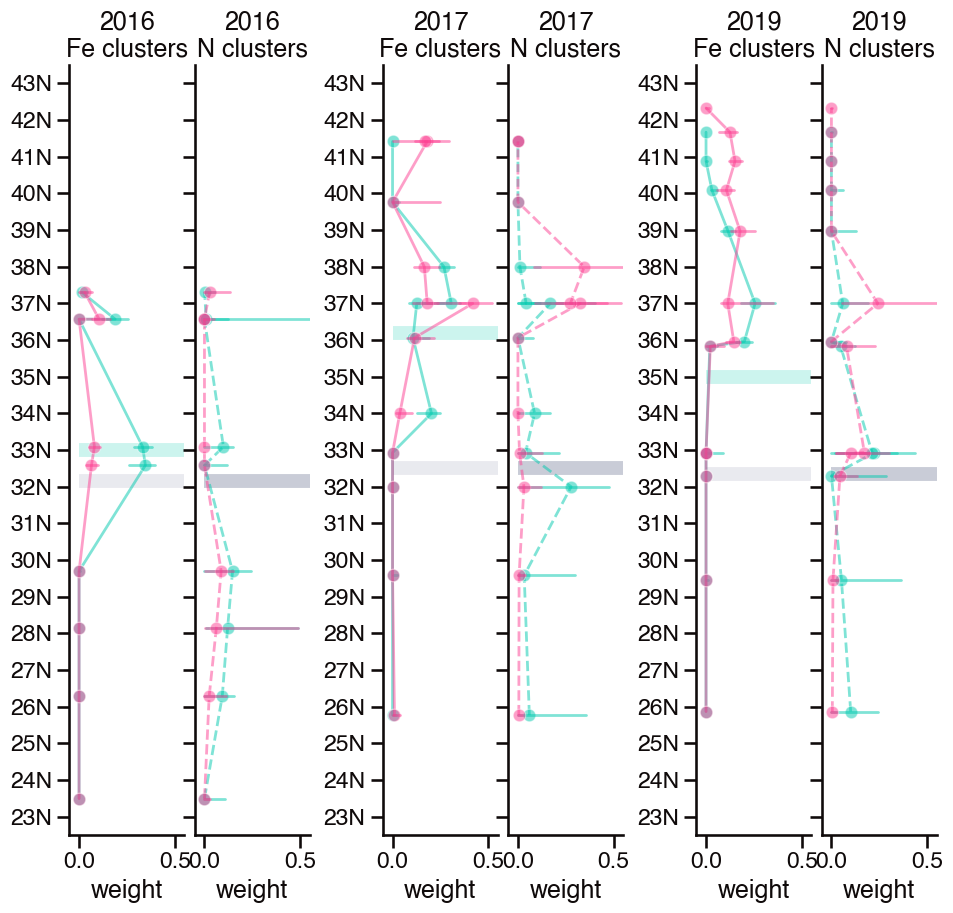

In [18]:
# plot iron and nitrogen weights side by side

# set up figure
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(12, 10))
rows = 1
cols = 15
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
n_bins = 21
bounds = (23, 43)

# plot cluster weight data
for i, year in enumerate([2016, 2017, 2019]):
    # plot iron cluster data
    axis = plt.subplot(grid[0, 5*i:5*i+2])
    # plot salinity front
    axis.hlines(y=sal_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[5], alpha=0.2)
    # plot chlorophyll front
    axis.hlines(y=chl_fronts[year], 
                xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[2], alpha=0.2)
    # get data together
    plot_df = fe_cluster_df[fe_cluster_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.lineplot(
        data=plot_df, x='sampleweights', y='latitude', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], estimator='median', errorbar=('pi', 95), 
        err_style='bars', marker='o', linestyle='-', alpha=0.5, orient='y', legend=(i==cols-1), ax=axis
    )
    axis.set_yticks(np.linspace(bounds[0], bounds[1], n_bins), [f'{int(l)}N' for l in np.linspace(bounds[0], bounds[1], num=n_bins)])
    # sns.boxplot(
    #     data=plot_df, x='sampleweights', y='lat_idx', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
    #     palette=[sns.color_palette()[i] for i in [2, 3]], 
    #     orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    # )
    # axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])
    # set labels and such
    axis.set(xlim=sample_weight_range, xlabel='weight', ylim=(bounds[0]-0.5, bounds[1]+.5), ylabel='', 
             title='{}\nFe clusters'.format(year))

    # plot nitrogen cluster data
    axis = plt.subplot(grid[0, 5*i+2:5*i+4])
    # plot salinity front
    axis.hlines(y=sal_fronts[year], xmin=0, xmax=2, linewidth=10, color=sns.color_palette()[5], alpha=0.5)
    # get data together
    plot_df = n_cluster_df[n_cluster_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.lineplot(
        data=plot_df, x='sampleweights', y='latitude', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], estimator='median', errorbar=('pi', 95), 
        err_style='bars', marker='o', linestyle='--', alpha=0.5, orient='y', legend=(i==cols-1), ax=axis
    )
    axis.set_yticks(np.linspace(bounds[0], bounds[1], n_bins))
    # sns.boxplot(
    #     data=plot_df, x='sampleweights', y='lat_idx', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
    #     palette=[sns.color_palette()[i] for i in [2, 3]], 
    #     orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    # )
    # axis.set_yticks(np.arange(n_bins))
    # set labels and such
    axis.set(xlim=sample_weight_range, xlabel='weight', ylim=(bounds[0]-0.5, bounds[1]+.5), ylabel='', 
             title='{}\nN clusters'.format(year))
    axis.tick_params(left=True, labelleft=False)

fig.savefig('fe-n-clusters-surface.png', bbox_inches='tight')


# cluster ids:
- Fe:
    - Pro: pro8
    - Syn: syn5
- Nitrogen:
    - Pro: pro14
    - Syn: syn12


In [17]:
# pull out ecotype weights

with pd.option_context('mode.chained_assignment', None):
    pro8_eco_df = pro_ds.sel(component=8).taxonweights.to_series().reset_index()
    pro8_eco_df['genus'] = 'Prochlorococcus'
    pro8_eco_df['clustergroup'] = 'Fe limitation'
    pro14_eco_df = pro_ds.sel(component=14).taxonweights.to_series().reset_index()
    pro14_eco_df['genus'] = 'Prochlorococcus'
    pro14_eco_df['clustergroup'] = 'N acquisition'
    syn5_eco_df = syn_ds.sel(component=5).taxonweights.to_series().reset_index()
    syn5_eco_df['genus'] = 'Synechococcus'
    syn5_eco_df['clustergroup'] = 'Fe limitation'
    syn12_eco_df = syn_ds.sel(component=12).taxonweights.to_series().reset_index()
    syn12_eco_df['genus'] = 'Synechococcus'
    syn12_eco_df['clustergroup'] = 'N acquisition'
ecotype_df = pd.concat([pro8_eco_df, pro14_eco_df, syn5_eco_df, syn12_eco_df])

ecotype_df


,bootstrap,replicate,clade,taxonweights,genus,clustergroup
0,0,A,HLI,0.975034,Prochlorococcus,Fe limitation
1,0,A,HLII,0.206825,Prochlorococcus,Fe limitation
2,0,A,LLI,0.080816,Prochlorococcus,Fe limitation
3,0,B,HLI,0.976653,Prochlorococcus,Fe limitation
4,0,B,HLII,0.192034,Prochlorococcus,Fe limitation
...,...,...,...,...,...,...
1795,99,C,5.1A-II,0.201486,Synechococcus,N acquisition
1796,99,C,5.1A-III,0.080079,Synechococcus,N acquisition
1797,99,C,5.1A-IV,0.093935,Synechococcus,N acquisition
1798,99,C,5.1B-VII,0.764295,Synechococcus,N acquisition


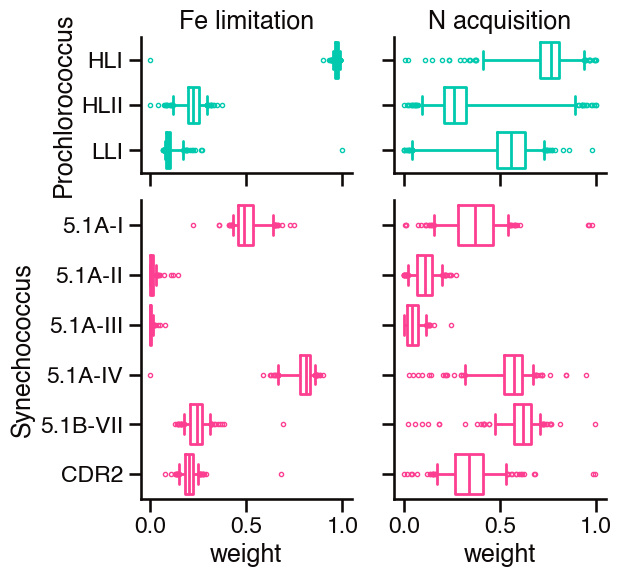

In [18]:
# make ecotype weight figure

# set up figure
sample_weight_range = (-0.05, 1.05) # range of weights to show on sample plots
fig = plt.figure(figsize=(6, 6))
rows = 3
cols = 2
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)

for i, genus in enumerate(['Prochlorococcus', 'Synechococcus']):
    for j, clustergroup in enumerate(['Fe limitation', 'N acquisition']):
        if not i:
            axis = plt.subplot(grid[i, j])
        else:
            axis = plt.subplot(grid[1:3, j])
        plot_df = ecotype_df[(ecotype_df['genus'] == genus) & (ecotype_df['clustergroup'] == clustergroup)]
        sns.boxplot(
            data=plot_df, x='taxonweights', y='clade', hue='genus', 
            hue_order=['Prochlorococcus', 'Synechococcus'], palette=[sns.color_palette()[i] for i in [2, 3]], 
            orient='y', fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
        )
        # labels and such
        if i == 0:
            axis.set(title=clustergroup)
        if i == 1:
            xlabel = 'weight'
        else:
            xlabel = None
        if j == 0:
            ylabel = genus
        else:
            ylabel = None
        axis.set(xlim=sample_weight_range, xlabel=xlabel, ylabel=ylabel)
        axis.tick_params(left=True, labelleft=(j==0), bottom=True, labelbottom=(i==1))

# save figure
fig.savefig('fe-n-clusters-taxonweights.png', bbox_inches='tight')


### incubations

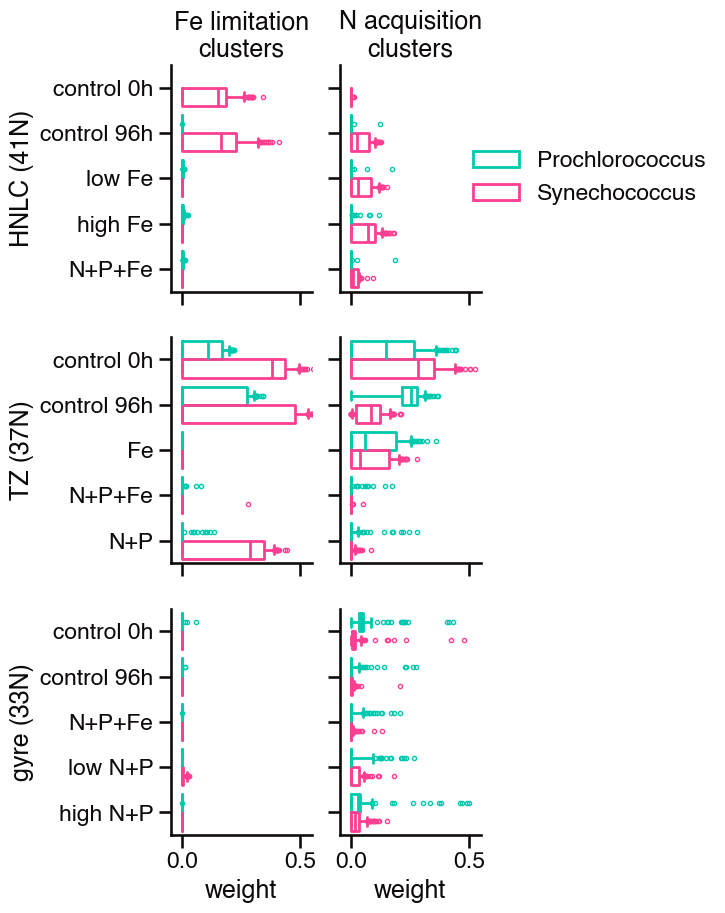

In [19]:
# incubation weights with both Fe and nitrogen clusters

# set up data
treatments = ['control 0h', 'control 96h', 'low Fe', 'high Fe', 'Fe', 'N+P+Fe', 'N+P', 'low N+P', 'high N+P']
with pd.option_context('mode.chained_assignment', None):
    fe_incubation_df = fe_cluster_df[fe_cluster_df.treatment.isin(treatments)]
    fe_incubation_df['clustergroup'] = 'Fe limitation'
    n_incubation_df = n_cluster_df[n_cluster_df.treatment.isin(treatments)]
    n_incubation_df['clustergroup'] = 'N acquisition'
incubation_df = pd.concat([fe_incubation_df, n_incubation_df]).reset_index(drop=True).fillna(0)
incubation_df = incubation_df.sort_values('treatment', key=lambda s: s.apply(treatments.index))

# set up figure
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(4, 10))
rows = 3
cols = 2
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)

for i, condition in enumerate(['HNLC', 'TZ', 'gyre']):
    for j, clustergroup in enumerate(['Fe limitation', 'N acquisition']):
        axis = plt.subplot(grid[i, j])
        plot_df = incubation_df[(incubation_df['condition'] == condition) & (incubation_df['clustergroup'] == clustergroup)]
        sns.boxplot(
            data=plot_df, x='sampleweights', y='treatment', hue='genus', 
            hue_order=['Prochlorococcus', 'Synechococcus'], palette=[sns.color_palette()[i] for i in [2, 3]], 
            orient='y', fill=False, whis=(5, 95), fliersize=3, legend=((i==0)&(j==1)), ax=axis
        )
        # labels and such
        if i == 0:
            axis.set(title='{}\nclusters'.format(clustergroup))
            if j == 1:
                axis.legend(loc='center left', bbox_to_anchor=(0.8, 0.5))
        if i == rows-1:
            xlabel = 'weight'
        else:
            xlabel = None
        if j == 0:
            ylabel = f"{condition} ({plot_df.latitude.mean():.0f}N)"
        else:
            ylabel = None
        axis.set(xlim=sample_weight_range, xlabel=xlabel, ylabel=ylabel)
        axis.tick_params(left=True, labelleft=(j==0), bottom=True, labelbottom=(i==rows-1))

# save figure
fig.savefig('fe-n-clusters-incubations.png', bbox_inches='tight')


# TODO

- pull out depth weights
